In [ ]:
import os
import random
import torch
import kagglehub
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from EnhanceAndSharpen import HistogramEnhanceAndSharpen
from SimpleCNN import SimpleCNN

In [2]:


# Download latest version
path = kagglehub.dataset_download("kaggleashwin/vehicle-type-recognition")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\kaggleashwin\vehicle-type-recognition\versions\1


In [3]:
# Hiển thị các tệp và thư mục con trong thư mục dataset
print("Contents:", os.listdir(path))


Contents: ['Dataset']


In [4]:
dataset_path = os.path.join(path, "Dataset")
print("Contents in Dataset:", os.listdir(dataset_path))


Contents in Dataset: ['Bus', 'Car', 'motorcycle', 'Truck']


In [ ]:
# def is_dark_image(img, dark_pixel_ratio_thresh=0.6):
#     gray = img.convert('L')
#     hist = gray.histogram()
#     total = sum(hist)
#     dark_pixels = sum(hist[:50])  # Pixel có giá trị 0–49
#     ratio = dark_pixels / total
#     return ratio > dark_pixel_ratio_thresh


In [5]:


# Biến đổi ảnh
transform = transforms.Compose([
    HistogramEnhanceAndSharpen(
        dark_pixel_ratio_thresh=0.6,
        brightness_factor=1.2,
        contrast_factor=1.2,
        apply_sharpen=True
    ),
    transforms.Resize((224, 224)),               # Resize ảnh về 224x224
    transforms.ToTensor(),                       # Chuyển ảnh PIL -> Tensor [C x H x W]
    transforms.Normalize(                        # Chuẩn hóa theo ImageNet
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Tạo dataset

dataset = ImageFolder(dataset_path, transform=transform)

train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)


Label classes: ['Bus', 'Car', 'Truck', 'motorcycle']
Labels batch: tensor([3, 3, 0, 2, 2, 3, 2, 3, 1, 1, 1, 0, 3, 0, 0, 3, 0, 2, 2, 2, 2, 1, 3, 1,
        1, 2, 2, 0, 3, 0, 1, 1])


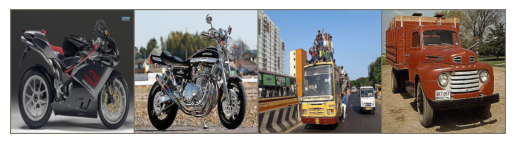

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Lấy 1 batch ảnh từ dataloader
images, labels = next(iter(train_loader))
print("Label classes:", dataset.classes)
print("Labels batch:", labels)

# Hiển thị ảnh  
imshow(torchvision.utils.make_grid(images[:4]))


In [ ]:
from SimpleCNN import SimpleCNN

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # In báo cáo
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    print("📉 Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


In [9]:

model = SimpleCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


class_names = ['Bus', 'Car', 'motorcycle', 'Truck']

print("\n Final Test Evaluation:")
evaluate(model, test_loader, class_names)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



 Final Test Evaluation:

📊 Classification Report:
              precision    recall  f1-score   support

         Bus     0.5556    0.2941    0.3846        17
         Car     0.6000    0.4615    0.5217        13
  motorcycle     0.2500    0.8571    0.3871         7
       Truck     0.9412    0.6957    0.8000        23

    accuracy                         0.5500        60
   macro avg     0.5867    0.5771    0.5234        60
weighted avg     0.6774    0.5500    0.5738        60

📉 Confusion Matrix:
[[ 5  3  9  0]
 [ 3  6  3  1]
 [ 0  1  6  0]
 [ 1  0  6 16]]


In [10]:
def predict_image(image_path):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, dim=1).item()
        class_name = dataset.classes[pred]
        return class_name


print(predict_image("image.jpg"))

motorcycle
